[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/sparks-baird/self-driving-lab-demo/blob/main/notebooks/6.2.1-multi-fidelity-continous.ipynb)

# Continous Multi-fidelity Optimization

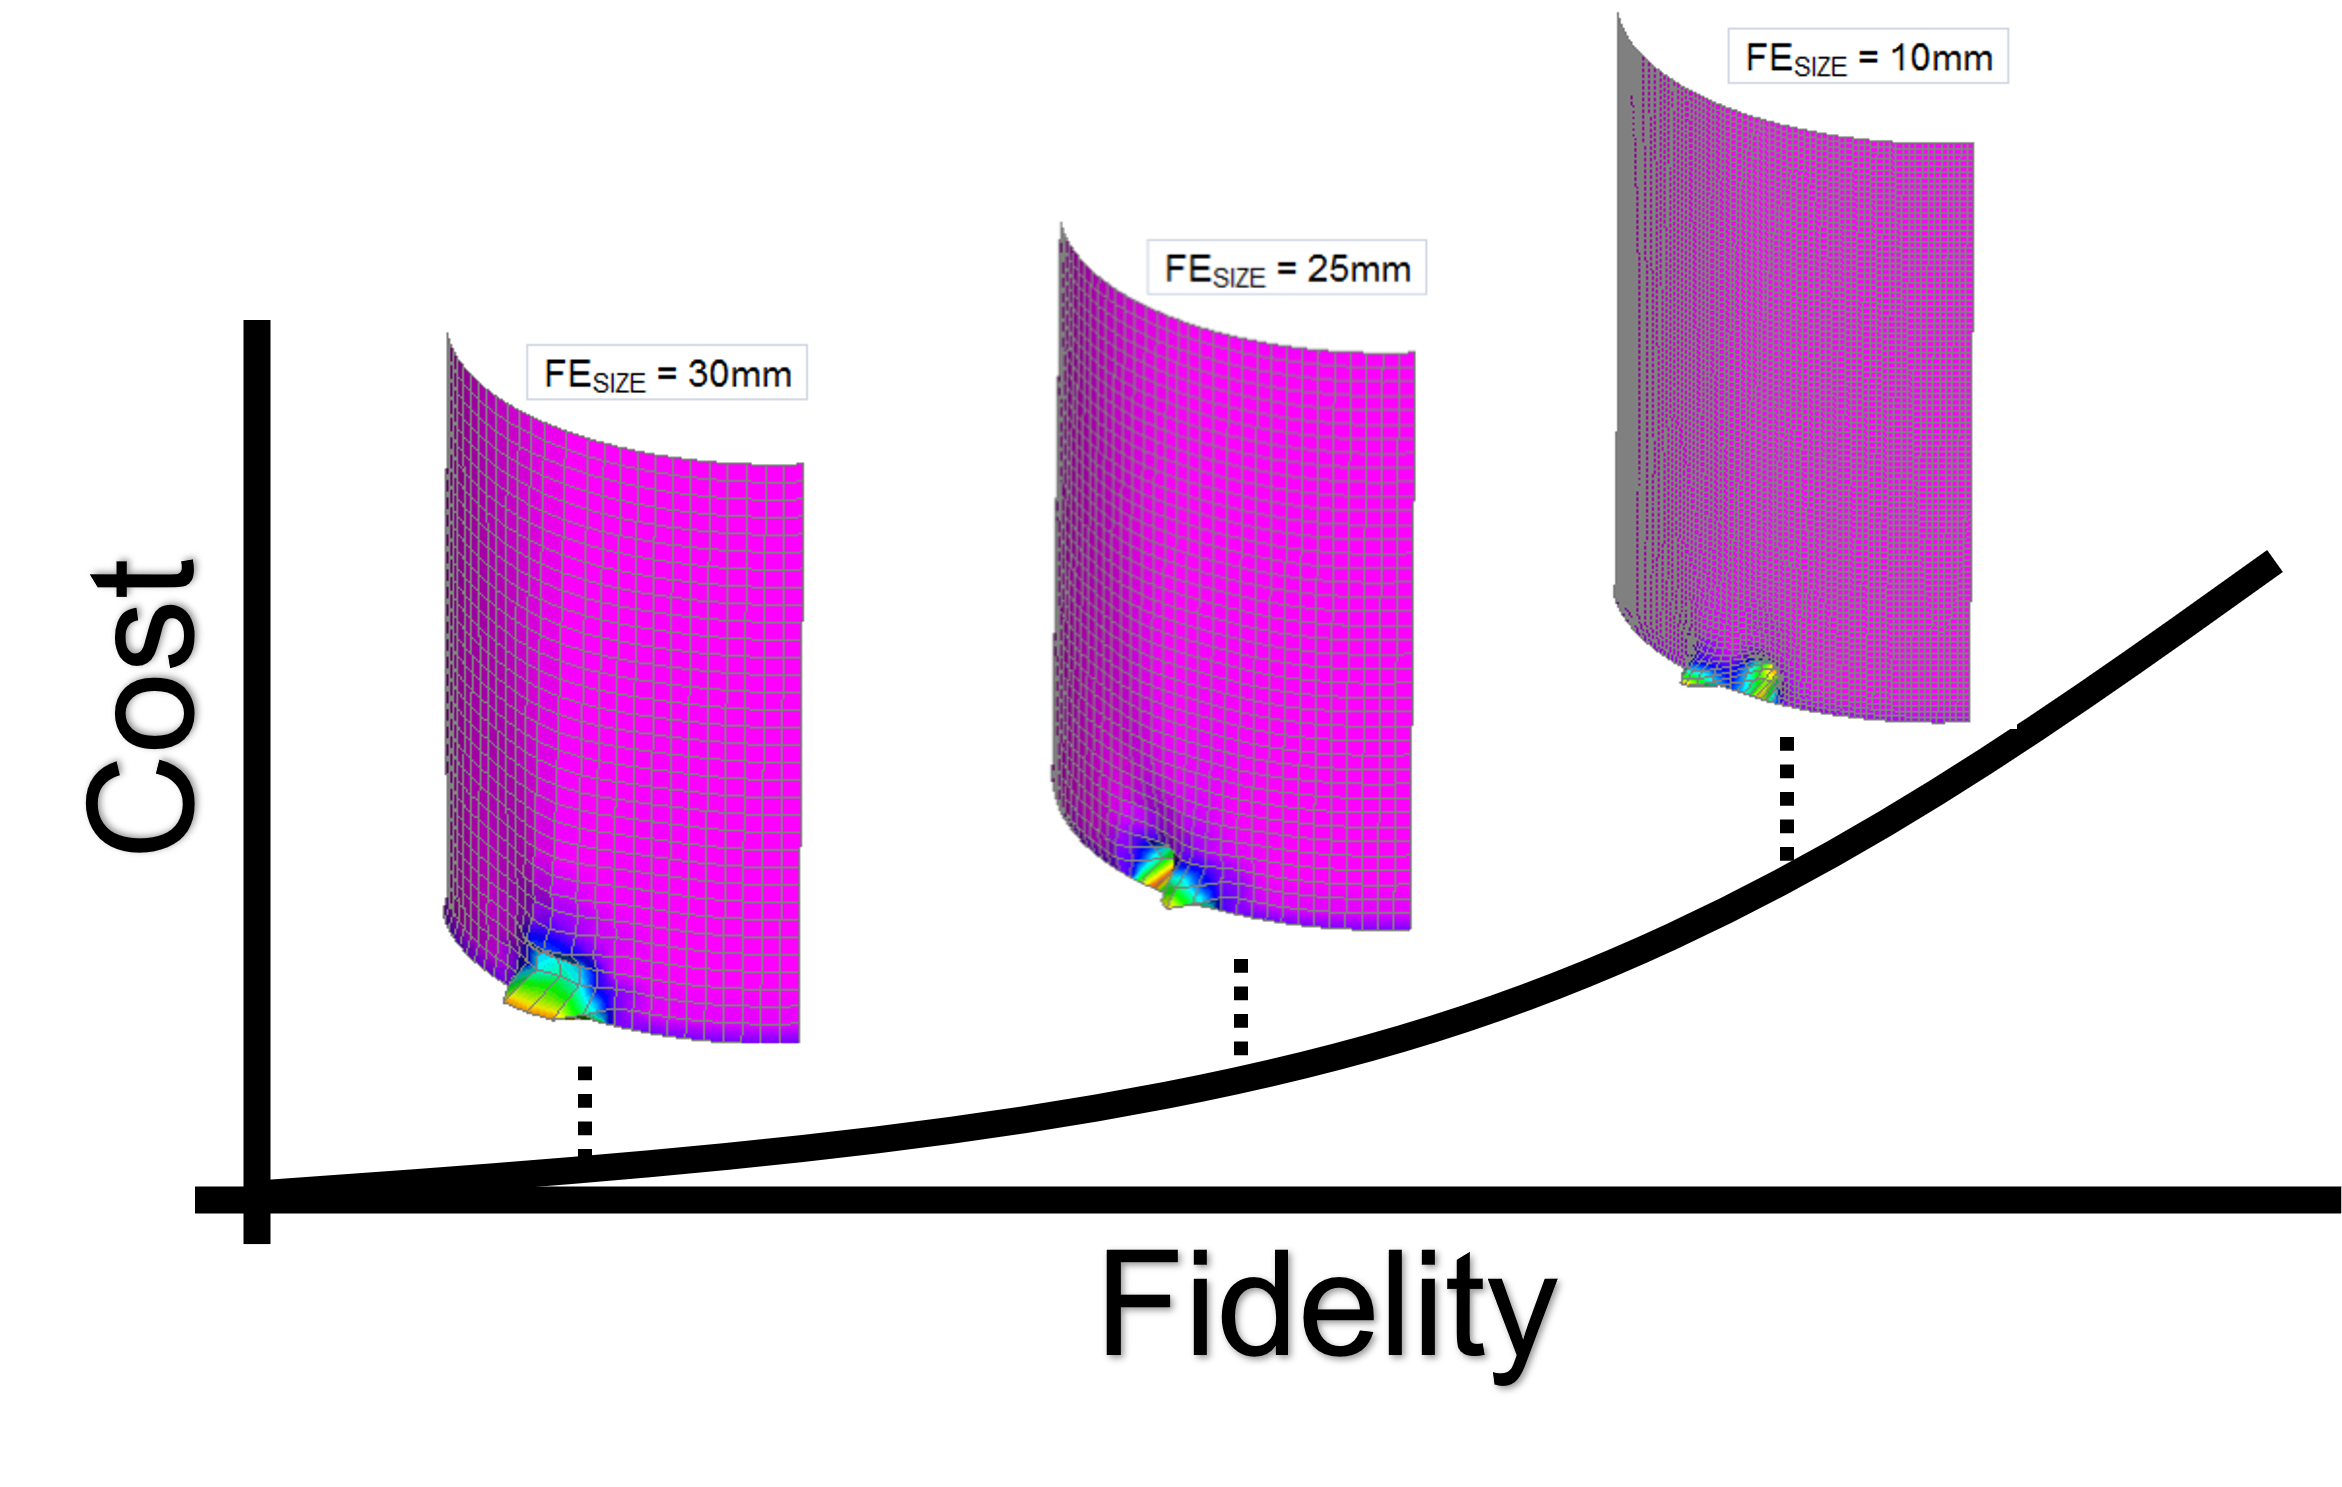

In [3]:
# For notebook gallery thumbnail
from IPython.display import Image
Image(filename="continuous-multi-fidelity.png")


In [the previous notebook](https://colab.research.google.com/github/sparks-baird/self-driving-lab-demo/blob/main/notebooks/6.2-multi-fidelity.ipynb), I provided a brief introduction of multi-fidelity
optimization in the context of the physical sciences. This notebook will cover
Bayesian optimization using two continuous fidelity parameters (`atime` and `astep`). We'll compare the total integration time using the
multi-fidelity optimization with the integration time costs of running the simulation at the
the lowest fidelities, the highest fidelities (default), and approximately halfway in-between. For validation, the
objective (in this case, `frechet`) will be evaluated at the upper bound of `atime` and `astep`. In
this experiment, we'll allow `atime` to vary between `0..100` (upper limit is 255) which is:
$2.78 \mu s .. 280.78\mu s$. Since multiple fidelity parameters [aren't yet supported
with Ax](https://github.com/facebook/Ax/issues/1211) (i.e. requires using BoTorch directly), we'll fix `astep` to `999` (limits are `0..65534`). In terms
of physical integration time, this corresponds to lowest and highest integration times
of $278 \mu s$ and $281 ms$, respectively.

For reference, here are the docs for `atime` and `astep` (taken from [`public_mqtt_sdl_demo/lib/as7341_sensor.py`](https://github.com/sparks-baird/self-driving-lab-demo/blob/main/src/public_mqtt_sdl_demo/lib/as7341_sensor.py)):
```python
"""
...
atime : int, optional
    The integration time step size in 2.78 microsecond increments, by default 100
astep : int, optional
    The integration time step count. Total integration time will be (ATIME + 1)
    * (ASTEP + 1) * 2.78µS, by default 999, meaning 281 ms assuming atime=100
...
"""
```

We'll be using the Knowledge Gradient (KG) acquisition function. 

From [the BoTorch docs](https://botorch.org/tutorials/one_shot_kg):
> ### The one-shot Knowledge Gradient acquisition function
> The Knowledge Gradient (KG) (see [2, 3]) is a look-ahead acquisition function that quantifies the expected increase in the maximum of the modeled black-box function f from obtaining additional (random) observations collected at the candidate set x. KG often shows improved Bayesian Optimization performance relative to simpler acquisition functions such as Expected Improvement, but in its traditional form it is computationally expensive and hard to implement.
>
> ...
> 
> [2] P. Frazier, W. Powell, and S. Dayanik. A Knowledge-Gradient policy for sequential information collection. SIAM Journal on Control and Optimization, 2008.
> 
> [3] J. Wu and P. Frazier. The parallel knowledge gradient method for batch bayesian optimization. NIPS 2016.


In this tutorial, we'll still use Ax rather than delving into pure BoTorch code. Since
Ax doesn't yet support discrete fidelity parameters, for the next notebook, we'll use
BoTorch exclusively. BoTorch has [a tutorial for continuous multi-fidelity optimization](https://botorch.org/tutorials/multi_fidelity_bo#Multi-Fidelity-BO-in-BoTorch-with-Knowledge-Gradient)
which has been [adapted for Ax in a GitHub
issue](https://github.com/facebook/Ax/issues/475). We will largely base the
implementation on the example from the GitHub issue.

As before, we need to set up our `SelfDrivingLabDemo` classes. We will use the
physical experimental setting since the simulations use only a simple multiplier to account for
integration time. We'll also use the same `frechet` objective function.

In [2]:
try:
    import google.colab
    %pip install self-driving-lab-demo
except:
    pass

In [3]:
from uuid import uuid4  # universally unique identifier
from self_driving_lab_demo import SelfDrivingLabDemo, mqtt_observe_sensor_data

dummy = False # @param {type:"boolean"}

pico_id = "test"  # @param {type:"string"}
if dummy:
    num_repeats = 2
    atime_max = 5
    astep_max = 5
else:
    num_repeats = 5   # @param {type:"integer"}
    atime_max = 100
    astep_max = 999 # fixed for now (see note above)
    
simulation = False # @param {type:"boolean"}
SESSION_ID = str(uuid4())  # random session ID

def calc_integration_time_s(atime, astep):
    return ((atime + 1) * (astep + 1) * 2.78) / 1e6

# total seconds of integration time
time_limit_s = 3 * calc_integration_time_s(atime_max, astep_max)
seeds = range(10, 10 + num_repeats)
print(f"session ID: {SESSION_ID}")

sdls = [
    SelfDrivingLabDemo(
        autoload=True,  # perform target data experiment automatically
        simulation=simulation,
        observe_sensor_data_fn=mqtt_observe_sensor_data,  # (default)
        observe_sensor_data_kwargs=dict(pico_id=pico_id, session_id=SESSION_ID),
        target_seed=seed,
    )
    for seed in seeds
]

session ID: ed3dc704-d8c0-4f98-b48d-dd133ae6f445


In [4]:
bounds = dict(R=sdls[0].bounds["R"], G=sdls[0].bounds["G"], B=sdls[0].bounds["B"])
params = [dict(name=nm, type="range", bounds=bnd) for nm, bnd in bounds.items()]
atime_bnd = [0, atime_max] # instead of [0, 255]
astep_bnd = [0, astep_max] # instead of [0, 65534]
params.append(
    dict(
        name="atime",
        type="range",
        is_fidelity=True,
        bounds=atime_bnd,
        target_value=atime_bnd[1],
    )
)
params.append(
    dict(
        name="astep",
        type="fixed",
        value=astep_max,
    )
)
# params.append(
#     dict(
#         name="astep",
#         type="range",
#         is_fidelity=True,
#         bounds=astep_bnd,
#         target_value=astep_bnd[1],
#     )
# )
params


[{'name': 'R', 'type': 'range', 'bounds': [0, 89]},
 {'name': 'G', 'type': 'range', 'bounds': [0, 89]},
 {'name': 'B', 'type': 'range', 'bounds': [0, 89]},
 {'name': 'atime',
  'type': 'range',
  'is_fidelity': True,
  'bounds': [0, 100],
  'target_value': 100}]

In [5]:
from ax.service.ax_client import AxClient
from botorch.test_functions.multi_fidelity import AugmentedHartmann
from ax.modelbridge.generation_strategy import GenerationStep, GenerationStrategy
from ax.modelbridge.registry import Models
from ax.service.utils.instantiation import ObjectiveProperties
import torch

integration_time_name = "integration_time_s"
ax_clients = []
batch_size = 1
num_sobol = 6
objectives = {"frechet": ObjectiveProperties(minimize=True)}

for sdl in sdls:

    def evaluate(parameters):
        R = parameters["R"]
        G = parameters["G"]
        B = parameters["B"]
        atime = parameters["atime"]
        astep = parameters["astep"]
        results = sdl.evaluate(R=R, G=G, B=B, atime=atime, astep=astep)
        results[integration_time_name] = calc_integration_time_s(atime, astep)
        # remove channel names to prevent extra tracking metrics warnings
        [results.pop(ch) for ch in sdl.channel_names]
        return results

    gs = GenerationStrategy(
        steps=[
            GenerationStep(model=Models.SOBOL, num_trials=num_sobol),
            GenerationStep(model=Models.GPKG, num_trials=-1),
        ]
    )

    ax_client = AxClient(generation_strategy=gs)
    ax_client.create_experiment(
        name="sdl_demo_mf_experiment",
        parameters=params,
        objectives=objectives,
        tracking_metric_names=[integration_time_name],
        overwrite_existing_experiment=True,
    )
    
    running_integration_time_s = 0
    # Initial sobol samples
    for i in range(num_sobol):
        parameters, trial_index = ax_client.get_next_trial()
        ax_client.complete_trial(trial_index=trial_index, raw_data=evaluate(parameters))

    # KGBO
    while running_integration_time_s < time_limit_s:
        q_p, q_t = [], []
        # Simulate batches
        for q in range(batch_size):
            parameters, trial_index = ax_client.get_next_trial()
            q_p.append(parameters)
            q_t.append(trial_index)
        for q in range(batch_size):
            pi = q_p[q]
            ti = q_t[q]
            integration_time = calc_integration_time_s(pi["atime"], pi["astep"])
            running_integration_time_s = running_integration_time_s + integration_time
            if running_integration_time_s > time_limit_s:
                break
            ax_client.complete_trial(trial_index=ti, raw_data=evaluate(pi))
        
        if running_integration_time_s > time_limit_s:
            break
    
    ax_clients.append(ax_client)


[INFO 10-17 11:22:15] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 10-17 11:22:15] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter R. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-17 11:22:15] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter G. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-17 11:22:15] ax.service.utils.instantiation: Inferred value type of ParameterType.INT for parameter B. If that is not the expected value type, you can explicity specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 10-17 11:22:15] ax.service.utils.instan

In [6]:
ax_clients

[AxClient(experiment=Experiment(sdl_demo_mf_experiment)),
 AxClient(experiment=Experiment(sdl_demo_mf_experiment)),
 AxClient(experiment=Experiment(sdl_demo_mf_experiment)),
 AxClient(experiment=Experiment(sdl_demo_mf_experiment)),
 AxClient(experiment=Experiment(sdl_demo_mf_experiment))]